In [158]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

from matplotlib import pyplot as plt

## 3. Логистическая регрессия. Реализация

Функция ошибки для логистической регрессии в случае бинарной классификации называется бинарной кросс-энтропией и записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i))),$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}$$

Реализация логистической регрессии будет основана на оптимизации функции ошибки градиентным спуском.

В качестве экспериментальных данных возьмем датасет о доходах граждан в различных странах [Adult Income](https://archive.ics.uci.edu/ml/datasets/Adult) и сделаем необходимую предобработку.

In [ ]:
adult = pd.read_csv('./data/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])

In [ ]:
# Описание датасета

# with open('./data/adult.names', 'r') as f:
#     names = f.read()
# print(names)

In [ ]:
adult.head(2)

In [ ]:
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

In [ ]:
adult.head()

In [ ]:
# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

In [ ]:
adult.head()

In [ ]:
# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [ ]:
# Реализовать функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

In [ ]:
# Реализовать функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

In [ ]:
def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

In [ ]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)

In [ ]:
theta

In [ ]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [ ]:
# Сделать предсказания на тренировочной выборке и
# посчитать значение метрики accuracy и F1-score
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)

In [ ]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
y_pred = sigmoid(X_valid, theta) > 0.5

print_logisitc_metrics(y_valid, y_pred)

In [ ]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

In [ ]:
# Вычислить вероятности принадлежности классу 1 для каждого объекта из валидационной выборки
y_pred_proba = sigmoid(X_valid, theta)
calc_and_plot_roc(y_valid, y_pred_proba)

## 4. Добавление регуляризации

### 4.1. Оборачивание линейной регрессии в класс

In [ ]:
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    def optimize(self, X, y, start_theta, n_iters):
        theta = start_theta.copy()

        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)

        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

In [ ]:
class LinReg(RegOptimizer):
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)

        return grad
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = X.dot(self.theta)
        
        return y_pred

In [ ]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')
def prepare_boston_data():
    data = load_boston()
    X, y = data['data'], data['target']
    # Нормализовать даннные с помощью стандартной нормализации
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [ ]:
linreg = LinReg(0.01, 500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

### 4.2. Оборачивание логистической регрессии в класс

In [ ]:
class LogReg(RegOptimizer):
    def sigmoid(self, X, theta):
        return 1. / (1. + np.exp(-X.dot(theta)))
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)

        return grad
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = self.predict_proba(X) > 0.5
        
        return y_pred

In [ ]:
def prepare_adult_data():
    adult = pd.read_csv('./data/adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    
    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
    
    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [ ]:
logreg = LogReg(1., 300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

In [ ]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

В случаях линейной и логистической регрессии будем добавлять к функции ошибки регуляризующую часть как:
$$\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $\theta$ — вектор параметров линейной модели без фиктивного признака (intercept/bias term), $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации.

### 4.3. Добавление регуляризатора в линейную регрессию

После добавления регуляризации функция ошибки линейной регрессии будет выглядеть следующим образом:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} + \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2}$$
А ее градиент по параметру $\theta$:
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} = \frac{1}{n}X^T(X\theta - y) + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j}$$

In [ ]:
class LinRegRegularized(LinReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LinRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [ ]:
linreg = LinRegRegularized(alpha=0.01, lambd=0.05, n_iters=500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

### 4.4. Добавление регуляризатора в логистическую регрессию

Функция ошибки для логистической регрессии в случае бинарной классификации с регуляризатором записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i)))+\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}+\frac{\lambda}{m}\sum_{j}^{m}{\theta_j}$$

In [ ]:
class LogRegRegularized(LogReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LogRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [ ]:
logreg = LogRegRegularized(alpha=1., lambd=1., n_iters=300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

In [ ]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

## Задания - ML-3B. Классификация

In [1]:
import numpy as np

In [2]:
# ML-3B. Классификация  6. Логистическая регрессия. Часть II

# Задание 5.3

# Посчитайте  для данных в таблице (без нормализации). Укажите число с точностью до сотых:
y_pred = np.array([0.2,	0.8,	1,	0.6])
y_true = np.array([0, 0,	1,	1])
print(np.nansum(-y_true*np.log(y_pred) - (1-y_true)*np.log(1-y_pred)))

2.3434070875143007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [3]:
from sklearn.metrics import log_loss
real = [0,0,1,1]
pred = [0.2, 0.8, 1.0, 0.6]
log_loss(real, pred, normalize=False)

2.343407087514302

In [4]:
# Задание 5.4
# Посчитайте  для данных в таблице. Необходимо найти среднюю ошибку. Классификация на три класса:

pred = np.array([[0.2, 0.3, 0.5],  # probability of being in each of 3 classes
                 [0, 0, 1], 
                 [0.1, 0, 0.9]
                 ])
y = np.array([[0, 0, 1],   # each row a three class classification
              [0, 0, 1],
              [1, 0, 0]
              ])

observations_num = y.shape[0]
classes_num = y.shape[1]
multi_logloss = 0
for i in range(observations_num):
    for j in range(classes_num):
        multi_logloss += np.nansum(y[i][j] * np.log(pred[i][j]))
ave_multi_logloss = (-1/observations_num)*multi_logloss
print(round(ave_multi_logloss, 2))

1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


In [75]:
# Задание 6.1

# Постройте модель логистической регрессии при помощи sklearn. Используйте параметры по 
# умолчанию, обучите на всей выборке и посчитайте F1 score.

# Ответ округлите до сотых. Пример ввода: 5.55.

# *Если вы всё правильно посчитали, но система не принимает ваш ответ, 
# попробуйте другую версию sklearn.
import pandas as pd

adult = pd.read_csv(
    'adult.data',
    names=['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country', 'salary'
           ])

In [76]:
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(
    adult, 
    columns=['workclass', 'education', 'marital-status', 
             'occupation', 'relationship', 'race', 'sex'
             ])

# Нормализовать признаки
feat = ['age', 'education-num', 'hours-per-week', 
        'fnlwgt', 'capital-gain', 'capital-loss']
a_features = adult[feat].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, feat] = norm_features

# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

print(X.shape, y.shape)

(32561, 66) (32561,)


In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [78]:
clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)

pred.shape

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(32561,)

In [79]:
print(round(f1_score(y, y_pred), 2))

0.66


In [80]:
confusion_matrix(y, y_pred)

array([[23030,  1690],
       [ 3124,  4717]])

In [81]:
true_neg = 0
true_pos = 0
false_neg = 0
for i, j in zip(y, y_pred):
    if i == j and i == 0:
        true_neg += 1
    elif i == j and i == 1:
        true_pos += 1
    elif i == 1 and j == 0:
        false_neg += 1
print('true_neg:', true_neg, 'true_pos', true_pos, 'false_neg', false_neg)

true_neg: 23030 true_pos 4717 false_neg 3124


In [82]:
prob_score = clf.predict_proba(X)
print(prob_score.shape)

(32561, 2)


In [83]:
print(round(roc_auc_score(y, prob_score[:, 1]), 2))

0.91


In [89]:
# Задание 6.4
# Переберите коэффициенты L2-регуляризации от 0.01 до 1 с шагом 0.01 и определите, на каком из 
# них модель логистической регрессии из sklearn даёт наибольший  F1.

# Ответ округлите до сотых. 
c_val = np.arange(0.01, 1, 0.01)
f1_scores = []
# for c in c_val:
#     clf = LogisticRegression(penalty='l2', C=c).fit(X, y)
#     y_pred = clf.predict(X)
#     f1_scores.append(f1_score(y, y_pred))

In [87]:
c_val[np.array(f1_scores).argmax()]

0.88

In [88]:
np.array(f1_scores).argmax()

87

In [70]:
# Задание 6.5
# Замените в столбце native-country страны, у которых меньше ста записей, на other, 
# поменяйте этот столбец на dummy-переменные, обучите классификатор на всей выборке 
# и посчитайте  F1.
# Ответ округлите до сотых. Пример ввода: 5.55.

adult = pd.read_csv(
    'adult.data',
    names=['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country', 'salary'
           ])

In [71]:
country_counts = adult['native-country'].value_counts()
for country in country_counts.index:
    if country_counts[country] < 100:
        adult.loc[adult['native-country'] == country, 'native-country'] = 'other'

adult['native-country'].value_counts()

 United-States    29170
other              1389
 Mexico             643
 ?                  583
 Philippines        198
 Germany            137
 Canada             121
 Puerto-Rico        114
 El-Salvador        106
 India              100
Name: native-country, dtype: int64

In [72]:
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,other,<=50K


In [73]:
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(
    adult, 
    columns=['workclass', 'education', 'marital-status', 
             'occupation', 'relationship', 'race', 'sex',
             'native-country'
             ])

# Нормализовать признаки
feat = ['age', 'education-num', 'hours-per-week', 
        'fnlwgt', 'capital-gain', 'capital-loss']

a_features = adult[feat].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, feat] = norm_features

# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

print(X.shape, y.shape)

(32561, 76) (32561,)


In [74]:
clf = LogisticRegression().fit(X, y)
y_pred = clf.predict(X)

print(round(f1_score(y, y_pred), 2))

0.66


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [90]:
# Курс  02 - Математика и алгоритмы для машинного обучения  ML-3B. 
# Классификация  8. Метрики качества классификации

# Задание 2.1

# Вы создали классификатор, который разделяет экономические и политические новости на два разных 
# Telegram-канала, и теперь хотите проверить качество классификатора. За день вышло 15 
# политических новостей и 20 экономических.
# Ваш алгоритм из 15 политических новостей отметил 9 как экономические, 
#  из 20 экономических — 6 как политические.
# Найдите метрику Accuracy.
# Ответ округлите до сотых.

round((6+14)/35, 2)

0.57

In [100]:
# Задание 2.2

# Загрузите встроенный в библиотеку sklearn датасет про ирисы с помощью
# функции load_iris. Обучите модель логистической регрессии (random_state=50, 
# размер тестовой выборки 0.3) и укажите полученное значение метрики Accuracy.
# Ответ округлите до сотых.

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50)

clf = LogisticRegression(random_state=50).fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [114]:
clf.score(X_test, y_test)

0.9777777777777777

In [106]:
y_test.shape

(45,)

In [116]:
y_test

array([1, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1,
       0, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 0, 1, 2, 1, 0, 0, 1, 2, 0,
       2])

In [115]:
confusion_matrix(y_test, y_pred)

array([[14,  0,  0],
       [ 0, 16,  1],
       [ 0,  0, 14]])

In [151]:
# У вас есть датасет с параметрами мобильных телефонов. Переменная price_range отвечает за то, 
# к какой категории относится телефон: 1 — дорогие, 0 — дешевые.
mob = pd.read_csv('train_mobile.csv', sep=';')
print(mob.shape)
mob.head()

(2000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,1
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,1
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,1
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,0


In [152]:
mob.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [153]:
mob.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [154]:
mob.corr()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
battery_power,1.000000,0.011252,0.011482,-0.041847,0.033334,0.015665,-0.004004,0.034085,0.001844,-0.029727,0.031441,0.014901,-0.008402,-0.000653,-0.029959,-0.021421,0.052510,0.011522,-0.010516,-0.008343,0.149402
blue,0.011252,1.000000,0.021419,0.035198,0.003593,0.013443,0.041177,0.004049,-0.008605,0.036161,-0.009952,-0.006872,-0.041533,0.026351,-0.002952,0.000613,0.013934,-0.030236,0.010061,-0.021863,0.014001
clock_speed,0.011482,0.021419,1.000000,-0.001315,-0.000434,-0.043073,0.006545,-0.014364,0.012350,-0.005724,-0.005245,-0.014523,-0.009476,0.003443,-0.029078,-0.007378,-0.011432,-0.046433,0.019756,-0.024471,0.003494
dual_sim,-0.041847,0.035198,-0.001315,1.000000,-0.029123,0.003187,-0.015679,-0.022142,-0.008979,-0.024658,-0.017143,-0.020875,0.014291,0.041072,-0.011949,-0.016666,-0.039404,-0.014008,-0.017117,0.022740,0.009002
fc,0.033334,0.003593,-0.000434,-0.029123,1.000000,-0.016560,-0.029133,-0.001791,0.023618,-0.013356,0.644595,-0.009990,-0.005176,0.015099,-0.011014,-0.012373,-0.006829,0.001793,-0.014828,0.020085,0.022464
four_g,0.015665,0.013443,-0.043073,0.003187,-0.016560,1.000000,0.008690,-0.001823,-0.016537,-0.029706,-0.005598,-0.019236,0.007448,0.007313,0.027166,0.037005,-0.046628,0.584246,0.016758,-0.017620,0.001001
int_memory,-0.004004,0.041177,0.006545,-0.015679,-0.029133,0.008690,1.000000,0.006886,-0.034214,-0.028310,-0.033273,0.010441,-0.008335,0.032813,0.037771,0.011731,-0.002790,-0.009366,-0.026999,0.006993,0.022132
m_dep,0.034085,0.004049,-0.014364,-0.022142,-0.001791,-0.001823,0.006886,1.000000,0.021756,-0.003504,0.026282,0.025263,0.023566,-0.009434,-0.025348,-0.018388,0.017003,-0.012065,-0.002638,-0.028353,-0.018554
mobile_wt,0.001844,-0.008605,0.012350,-0.008979,0.023618,-0.016537,-0.034214,0.021756,1.000000,-0.018989,0.018844,0.000939,0.000090,-0.002581,-0.033855,-0.020761,0.006209,0.001551,-0.014368,-0.000409,-0.007968
n_cores,-0.029727,0.036161,-0.005724,-0.024658,-0.013356,-0.029706,-0.028310,-0.003504,-0.018989,1.000000,-0.001193,-0.006872,0.024480,0.004868,-0.000315,0.025826,0.013148,-0.014733,0.023774,-0.009964,0.031260


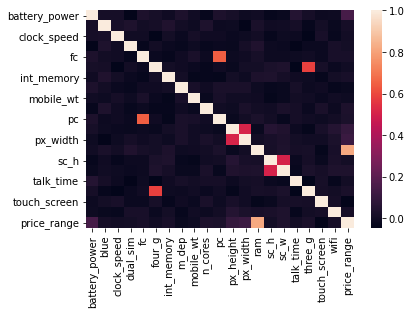

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(mob.corr())

In [156]:
'ram', 'battary_power', 'px_width', 'px_height', 'sc_w'

('ram', 'battary_power', 'px_width', 'px_height', 'sc_w')

In [157]:
corr_df = mob.corr()

In [150]:
mob.shape

(2000, 21)

In [164]:
corr_df = mob.corr()
columns = corr_df['price_range'].apply(abs).sort_values(ascending=False)[1:6].index
print(columns.values)

# ['ram' 'battery_power' 'px_width' 'px_height' 'sc_w']

['ram' 'battery_power' 'px_width' 'px_height' 'touch_screen']


In [165]:
# ШАГ 2
# Теперь необходимо обучить алгоритм.  Для начала разбейте выборку на тестовую и 
# обучающую, размер тестовой задайте 0.2. Параметр random_state=31. 
# В качестве модели возьмите логистическую регрессию. 
# В качестве предикторов возьмите пять ранее отобранных признаков.

# Рассчитайте метрику precision, которая покажет, какая доля телефонов, обозначенных классификатором 
# как дорогие, действительно относится к этой категории. 

X = mob[columns]
y = mob['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [166]:
# Задание 3.3. Значение метрики
# Введите полученное значение, округлите до четырех знаков после запятой.
round(precision_score(y_test, y_pred), 4)

0.9859